# CNN for DOA estimation

### Imports

In [1]:
import math
import sys
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize
from pyroomacoustics.transform import stft

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler

from joblib import dump, load

%matplotlib inline

### Constants

In [2]:
# Label resolution of classification
RESOLUTION = 10

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

AUDIO_PATH = '../training_data/audio'

# Number of microphones on the array
MICS_NUMBER = 6

MIC_COMBS = len(list(combinations(range(MICS_NUMBER), 2)))

### Utils

In [3]:
def plot_cm(y_true, y_pred, class_names):
    """
    Plots a confusion matrix between actual and predicted labels.
    """
    
    register_matplotlib_converters()
    sns.set(style='whitegrid', palette='muted', font_scale=0.8)
    rcParams['figure.figsize'] = 22, 10
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(24, 20)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt=".3f", 
        cmap=sns.diverging_palette(220, 20, n=7),
        ax=ax
    )

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    

def get_entries_with_property(info, prop, value):
    if prop == 'distance': i = 0
    elif prop == 'snr': i = 1
        
    info = info[:, i]
    return np.where(info == value)

### Creating a room for simulation

In [97]:
def create_simulation_room(room_dim=[4, 4, 3], mic_pos=[2, 2, 1.5], room_fs=16000):
    """
    Utility function to create a shoebox room,
    with a microphone array included.
    """
    
    # Initialize room
    room = pra.ShoeBox(room_dim, fs=room_fs)

    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.045

    # Generate the microphone array
    mic_array_2D = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=mic_radius)
    mic_array_3D = np.vstack((mic_array_2D, [mic_height] * 6))
    
    # Add the microphone array to room
    room.add_microphone_array(mic_array_3D)
    
    return room


def create_sound_sources(room_dim=[4, 4, 3], resolution=1):
    """
    Function that creates a list of all audio source,
    that will be placed inside the room for simulation.
    """
    
    wall_len = room_dim[0] / 2
    
    #Specify angle in distance ranges
    angle_range = range(0, 360, resolution)
    dist_range = np.linspace(0.5, wall_len, 3)
    height_range = np.linspace(0, room_dim[-1], 3)
   
    sources = defaultdict(list)

    for angle in angle_range:
        for R in dist_range:
            for h in height_range:
                source = [R * math.cos(math.radians(angle)) + wall_len, 
                          R * math.sin(math.radians(angle)) + wall_len, h]
                sources[angle].append((R, h, source))
            
    return sources


def simulate_room(audio_file, subset, room_type='small', mic_pos=[2, 2, 1.5], label_res=20):
    """
    Function to simulate room with specified dimensions and microphone array position.
    Generates CSV files for all angle/distance combinations.
    
    Returns: a dictionary with all dataframes that were created.
    Keys are in a form of (angle, distance) tuples
    """
    
    file_name = os.path.basename(audio_file).split('.')[0]
    
    # Read the audio file
    fs, audio = wavfile.read(audio_file)
    
    # Get room dimensions
    if subset == 'train':
        room_dim = ROOMS[room_type]
    else:
        room_dim = TEST_ROOMS[room_type]
    
    # Create all sound sources
    sources = create_sound_sources(room_dim)
    
    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        if angle % label_res == 0:
            print(f'Simulating {angle}-{angle + label_res - 1} degrees:', end=' ')
            
        sys.stdout.write("#")
        
        wav_signals = defaultdict(list)
        
        for dist, height, source in sources:
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs)
            room.add_source(source, signal=audio, delay=0.0)
            room.simulate()

            # Extract simulated signal for each microphone
            data = room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            
            # Append simulated data to the final WAV signals
            wav_signals[dist].extend(data)
            
        # Save WAV files containing 6 channel data for all distances at given angle
        for dist in wav_signals:
            save_name = f'{subset}_angle_{angle}_dist_{int(dist*100)}_room_{room_type}_{file_name}.wav'
            wavfile.write(f'{AUDIO_PATH}/{save_name}', fs, np.array(wav_signals[dist]))
        
        if angle % label_res == label_res - 1:
            print(' Done.')
            
    print('Simulation successful!')

In [106]:
# Simulate room for every audio file in the directory
training_sounds = os.listdir('../sounds/training')
testing_sounds = os.listdir('../sounds/testing')

print('Simulating training data:\n')
for sound in training_sounds:
    for room, dim in ROOMS.items():
        # Call the function above and store all results
        print('Audio file: ' + sound)
        print(f'Room: {room}')
        dataframes = simulate_room(f'../sounds/training/{sound}', 'train', room, dim / 2, label_res=60)
        
        
print('\nSimulating testing data:\n')
for sound in testing_sounds:
    for room, dim in TEST_ROOMS.items():
        # Call the function above and store all results
        print('Audio file: ' + sound)
        print(f'Room: {room}')
        dataframes = simulate_room(f'../sounds/testing/{sound}', 'test', room, dim / 2, label_res=60)


Simulating testing data:

Audio file: StarWars1.wav
Room: small
Simulating 0-59 degrees: ############################################################ Done.
Simulating 60-119 degrees: ############################################################ Done.
Simulating 120-179 degrees: ############################################################ Done.
Simulating 180-239 degrees: ############################################################ Done.
Simulating 240-299 degrees: ############################################################ Done.
Simulating 300-359 degrees: ############################################################ Done.
Simulation successful!
Audio file: StarWars1.wav
Room: medium
Simulating 0-59 degrees: ############################################################ Done.
Simulating 60-119 degrees: ############################################################ Done.
Simulating 120-179 degrees: ############################################################ Done.
Simulating 180-239 degrees

### Checking if the simulation room, sources and microphones are properly generated

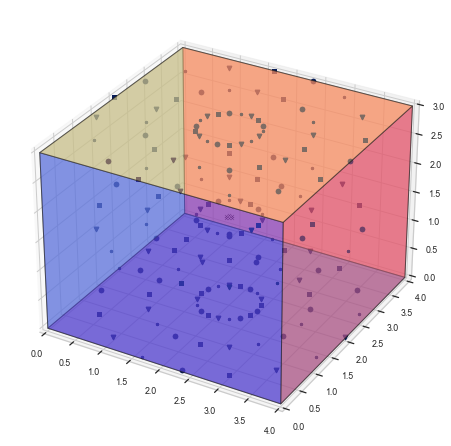

In [101]:
room_dim = ROOMS['small']

room = create_simulation_room(room_dim, mic_pos=room_dim / 2)
sources = create_sound_sources(room_dim, resolution=20)
fs, audio = wavfile.read("../sounds/training/CantinaBand3.wav")

# Add every single source to the room
for angle, sources in sources.items():
    for _, _, source in sources:
        room.add_source(source, signal=audio, delay=0.5)

# Plot the room
fig, ax = room.plot()
fig.set_size_inches(6, 6)
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, room_dim[2]]);

Check if simulated data is properly stored in WAV files:

In [107]:
fs, audio = wavfile.read("../training_data/audio/test_angle_0_dist_50_room_small_StarWars1.wav")
cols = [f'mic_{i}' for i in range(1, 7)]
df = pd.DataFrame(data=audio, columns=cols, dtype=np.int16)
df.iloc[2000:2010]

,mic_1,mic_2,mic_3,mic_4,mic_5,mic_6
2000,-2288,-3443,-2888,-4316,-2888,-3443
2001,-606,-1346,-3102,-3026,-3102,-1346
2002,-2060,-1427,-1739,-1794,-1739,-1427
2003,-2702,-2216,-1213,-425,-1213,-2216
2004,-572,-1929,-1945,-781,-1945,-1929
2005,-2231,-1,-2192,-2757,-2192,-1
2006,-3857,-3751,-210,-2988,-210,-3751
2007,1122,-2993,-3140,-893,-3140,-2993
2008,205,932,-4971,-4236,-4971,932
2009,529,256,554,-2372,554,256


Plot 50 samples from each channel together:

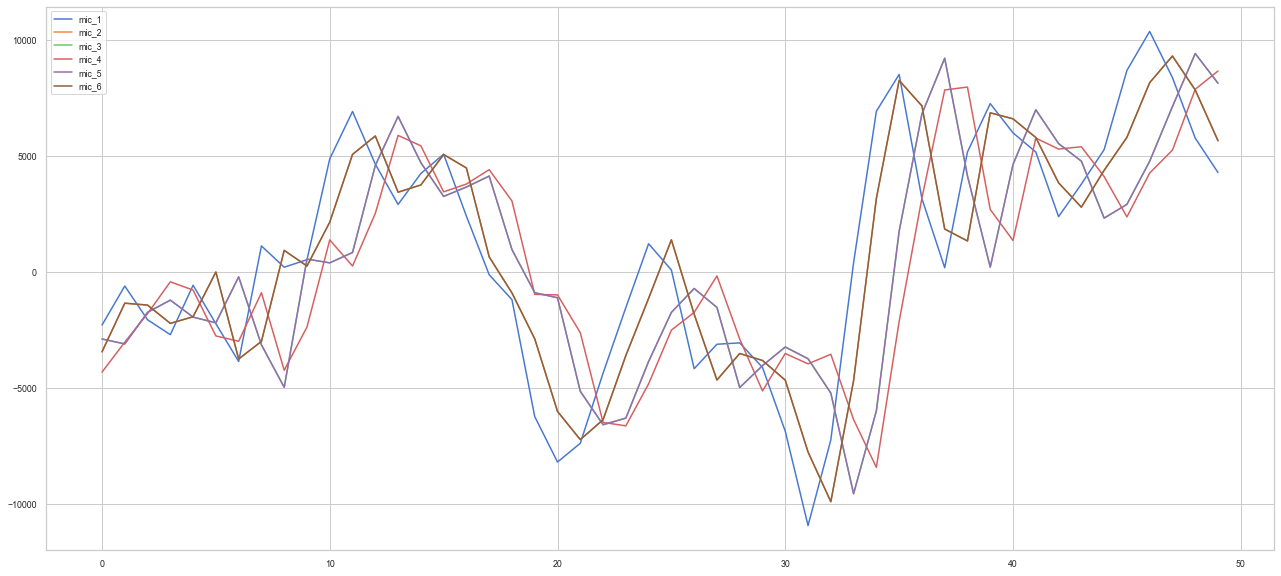

In [108]:
sample = audio[2000:2050]

for mic in range(len(sample[0])):
    plt.plot(sample[:, mic], label=f'mic_{mic+1}')
    
plt.legend()
plt.show()

### Creating training and testing datasets

In [35]:
def gcc_phat(x_1, x_2, FS=16000):
    """
    Function that will compute the GCC-PHAT
    cross-correlation of two separate audio channels
    
    Returns:
        A 1-D GCC vector
    """
    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
     # Normalize by the magnitude of FFT - because PHAT
    np.divide(X_1, np.abs(X_1), X_1, where=np.abs(X_1) != 0)
    np.divide(X_2, np.abs(X_2), X_2, where=np.abs(X_2) != 0)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See http://www.xavieranguera.com/phdthesis/node92.html for reference
    CC = X_1 * np.conj(X_2)
    cc = np.fft.irfft(CC, n=n)
        
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.09 m is the mic array diameter and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.09 / 340 * FS)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc


def compute_gcc_matrix(observation, fs):
    """
    Creates a GCC matrix, where each row is a vector of GCC 
    between a given pair of microphones.
    """
    
    mic_pairs = combinations(range(6), r=2)

    # Initialize a transformed observation, that will be populated with GCC vectors
    # of the observation
    transformed_observation = []

    # Compute GCC for every pair of microphones
    for mic_1, mic_2 in mic_pairs:
        x_1 = observation[:, mic_1]
        x_2 = observation[:, mic_2]

        gcc = gcc_phat(x_1, x_2, FS=fs)

        # Add the GCC vector to the GCC matrix
        transformed_observation.append(gcc)    
        
    return transformed_observation


def create_observations(wav_signals, fs, label, samples=1, step=1, resolution=20, music=False):
    """
    Create list of observations from the pandas dataframe.
    Each observation will be a GCC matrix, where each row 
    is a vector of GCC between a given pair of microphones.
    
    Returns: 
        a tuple of observations and their corresponding labels
    """
    
    # Lists of observations and labels that will be populated
    X = []
    y = []
    
    rounded_label = round(label / resolution) * resolution
    if rounded_label == 360: rounded_label = 0
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        y.append(rounded_label)
        
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
        
        if music:
            # Transform observation into a STFT matrix
            transformed_observation = compute_stft_matrix(observation)
        else:
            # Transform observation into a GCC matrix
            transformed_observation = compute_gcc_matrix(observation, fs)
            transformed_observation = transformed_observation
            
        X.append(transformed_observation)

    return X, y


def one_hot_encode(encoder, y_train, y_test):
    """
    Creates a one-hot encoding of categorical labels
    provided in y_train and y_test.
    """
    
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)
    
    return y_train, y_test
  
    
def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    """
    Creates an entire dataset by extracting values
    from train and tests dataframes.
    
    One-hot encodes the labels before returning.
    """
    
    # Can filter testing entries to only check performance
    # for given conditions
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(['dist', 'room', 'label'], 1).values.reshape(
        len(df_train), MIC_COMBS, -1)
    X_test = df_test.drop(['dist', 'room', 'label'], 1).values.reshape(
        len(df_test), MIC_COMBS, -1)
    
    # Create train/test labels
    y_train, y_test = one_hot_encode(
        encoder, df_train['label'].values, df_test['label'].values)
    
    return X_train, y_train, X_test, y_test


def create_dataframe(subset, samples=20, step=5, resolution=20, is_info=True):
    """
    Creates a whole dataframe 
    It is achieved by looping through all WAV files in the directory
    and creating observations from each of them. 
    
    These observations are then all concatenated together 
    into one large dataframe
    
    Returns:
        a pandas dataframe containing all data points (without any splits)
    """
    
    dataframes = []
    
    files = [file for file in os.listdir(AUDIO_PATH) if subset in file]

    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue
            
        print(f'{subset} file {i+1}/{len(files)}', end='\r')

        path = os.path.join(AUDIO_PATH, file)
        fs, wav_signals = wavfile.read(path)
        
        label = int(file.split('_')[2])
        
        # Create observations from a given WAV file
        X_temp, y_temp = create_observations(wav_signals, fs, label, samples, step, resolution)
        
        cols = [
            f'mics{mic_1+1}{mic_2+1}_{i}' 
                for mic_1, mic_2 in combinations(range(6), r=2) 
                    for i in range(np.shape(X_temp)[2])
        ]
        
        df = pd.DataFrame(data=np.reshape(X_temp, (len(X_temp), -1)), columns=cols)
        
        # Add extra info columns
        if is_info:
            dist = int(file.split('_')[4])
            room = file.split('_')[6]
            df['dist'], df['room'] = dist, room
            
        # Add label column
        df['label'] = y_temp
        dataframes.append(df)
        
    return pd.concat(dataframes, ignore_index=True)

In [110]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()

df_train.to_csv('../training_data/train_dataset.csv')
df_test.to_csv('../training_data/test_dataset.csv')

# Create numpy arrays with observations and one-hot labels
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))
pd.set_option('display.max_columns', 15)
df_train.head(10)

test file 3240/3240
(628560, 15, 13) (210740, 15, 13) (628560, 36) (210740, 36)


,mics12_0,mics12_1,mics12_2,mics12_3,mics12_4,mics12_5,mics12_6,...,mics56_9,mics56_10,mics56_11,mics56_12,dist,room,label
0,-0.034105,0.007895,-0.015314,0.023924,-0.052866,0.606803,0.278412,...,-0.147017,-0.003311,-0.011371,-0.010007,125,small,0
1,-0.020058,-0.004374,-0.016010,0.031205,-0.050479,0.738530,0.150840,...,-0.105823,0.002591,-0.013768,-0.010265,125,small,0
2,-0.003666,-0.013881,-0.007180,0.048016,-0.041064,0.607168,0.295415,...,-0.056927,0.015567,-0.017853,0.016563,125,small,0
3,-0.021429,-0.008984,-0.016450,0.059877,-0.017896,0.783505,0.075530,...,-0.050990,0.011425,-0.008293,-0.007993,125,small,0
4,-0.007359,-0.004488,-0.028438,0.039098,-0.039597,0.632128,0.226010,...,-0.123003,0.014246,-0.008525,0.004416,125,small,0
5,-0.015604,-0.000561,-0.003038,0.056834,-0.026116,0.844842,0.076383,...,-0.040564,0.037731,0.006477,-0.007558,125,small,0
6,-0.016496,-0.002115,0.001366,0.062287,-0.025878,0.850883,0.077759,...,-0.037918,0.031222,0.000042,-0.004212,125,small,0
7,-0.018820,-0.015052,0.002991,0.070506,-0.017445,0.826160,0.077715,...,-0.033505,0.027035,0.012348,-0.003540,125,small,0
8,-0.010496,-0.001136,-0.018180,0.061375,-0.020284,0.841131,0.086829,...,-0.034561,0.018655,0.006290,-0.000412,125,small,0
9,-0.022396,0.016553,0.013846,0.038961,0.018950,0.733467,0.096558,...,0.007454,0.026289,0.037484,-0.025197,125,small,0


Only run this when all the variables are not stored in memory (i.e. after restarting the kernel):

In [36]:
df_train = pd.read_csv('../training_data/train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/test_dataset.csv', index_col=[0])
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((628560, 15, 13), (210740, 15, 13), (628560, 36), (210740, 36))

### Plot example GCC matrices for a few different angle labels

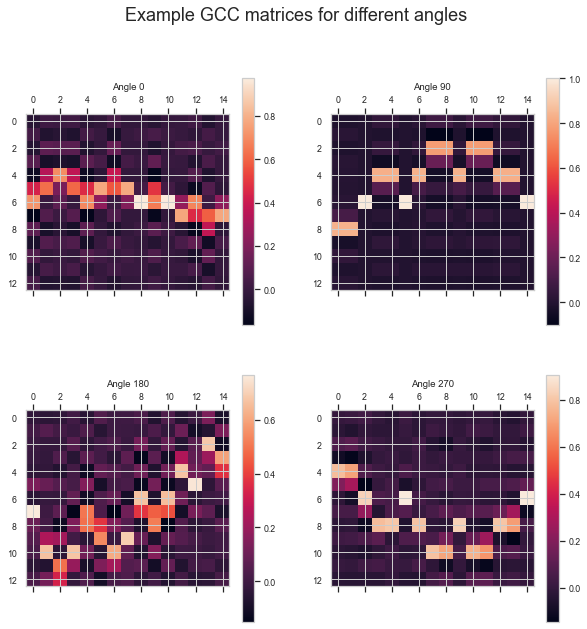

In [87]:
# Get training labels
angle_labels = encoder.inverse_transform(y_train)

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Example GCC matrices for different angles', fontsize=18)

for i, label in enumerate(np.unique(angle_labels)[::9]):
    ax = axs[i//2][i%2]
    indices = np.where(angle_labels == label)[0]
    obs_idx = indices[np.random.randint(len(indices))]
    
    observation = X_train[obs_idx]
    
    ax.set_title(f'Angle {label}')
    im = ax.matshow(observation)
    fig.colorbar(im, ax=ax)

### Testing MUSIC algorithm - baseline

In [123]:
def compute_stft_matrix(observation, nfft=256):
    """
    Creates a STFT matrix using microphone data from 6 channels.
    """
    
    # Default value for overlap
    step = nfft // 2
    
    # Calculate multidimensional STFT and return
    transformed_observation = stft.analysis(observation, L=nfft, hop=step)
    return np.transpose(transformed_observation, axes=[2, 1, 0])


def get_music_prediction(X, mic_pos=[2, 2, 1], fs=16000, nfft=256):
    """
    Calculates DOA based on MUSIC prediction.
    Returns:
        an angle in degrees in range 0-360 with resolution of 20
    """
    
    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.045

    # Generate the microphone array
    R = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=mic_radius)
    
    # Run MUSIC algorithm for DOA
    doa = pra.doa.MUSIC(R, fs, nfft, n_grid=360//RESOLUTION)
    doa.locate_sources(X)
    return round((doa.azimuth_recon[0] * 180 / math.pi))


def get_all_predictions(is_info=False, samples=20, step=5, resolution=20):
    """
    Returns a list of labels predicted by applying MUSIC.
    Observations are generated by taking every 10th observation
    from the entire data set (all audio files).
    
    Observation is a matrix of size (samples, channels), where
    channels is the number of microphones (6).
    """
    
    y_true = []
    y_pred = []
    info = []
    
    files = [file for file in os.listdir(AUDIO_PATH) if 'test' in file]
    
    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue

        path = os.path.join(AUDIO_PATH, file)
        fs, wav_signals = wavfile.read(path)
        label = int(file.split('_')[2])
        
        # Create observations from a given WAV file
        X, y = create_observations(wav_signals, fs, label, samples, step, resolution, True)

        if is_info:
            dist = int(file.split('_')[4])
            room = file.split('_')[6]
            y = [(dist, room, label) for label in y]
           
        # Store actual and predicted labels
        y_true.extend(y)
        preds = [get_music_prediction(x, fs=fs) for x in X]
        y_pred.extend(preds)
        
        print(f'File {i+1}/{len(files)}', end='\r')
       
    y_true = np.array(y_true)
    
    if is_info:
        info = y_true[:, :-1]
        y_true = list(y_true[:, -1].astype(int))
        return y_true, y_pred, info
        
    return y_true, y_pred

(210740,) (210740,)


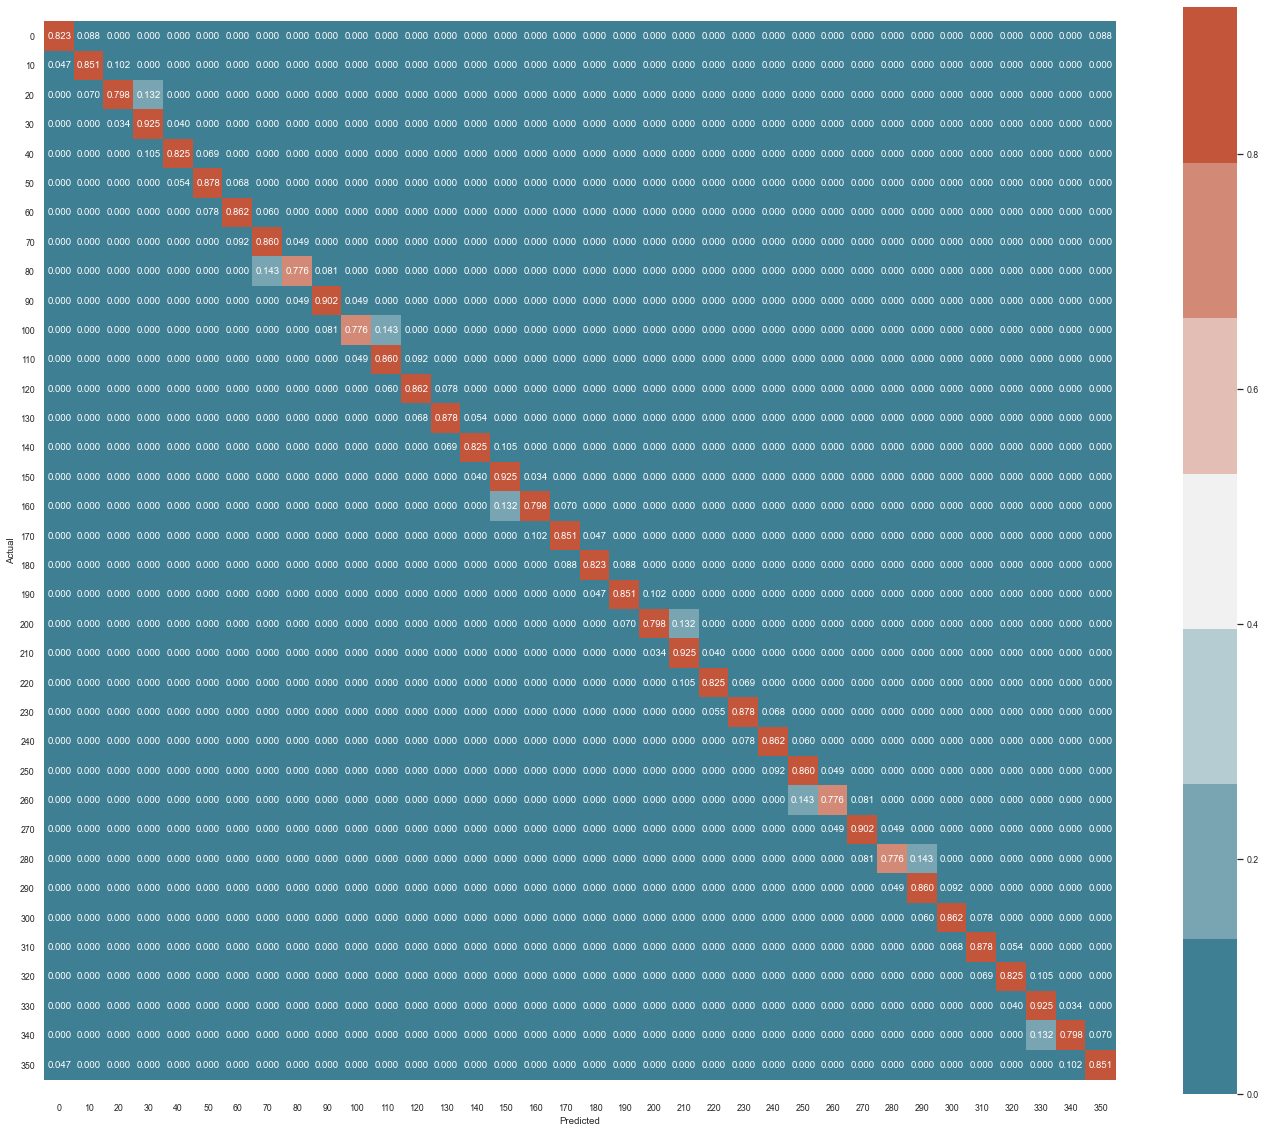

Accuracy: 0.845


In [124]:
# Run MUSIC prediction on the data set
y_true, y_pred, info = get_all_predictions(True, samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print(np.shape(y_true), np.shape(y_pred))

# Plot confusion matrix and report accuracy
plot_cm(y_true, y_pred, np.unique(y_true))
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {round(accuracy, 3)}')

### Initial CNN design

In [37]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((628560, 13, 15), (210740, 13, 15))

In [38]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# Init model
model = Sequential()

# Add layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
epochs, batch_size, verbose = 20, 32, 1
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/20
19643/19643 [==============================] - 37s 2ms/step - loss: 0.2237 - accuracy: 0.9139
Epoch 2/20
19643/19643 [==============================] - 38s 2ms/step - loss: 0.1211 - accuracy: 0.9533
Epoch 3/20
19643/19643 [==============================] - 33s 2ms/step - loss: 0.1027 - accuracy: 0.9607
Epoch 4/20
19643/19643 [==============================] - 34s 2ms/step - loss: 0.0924 - accuracy: 0.9653
Epoch 5/20
19643/19643 [==============================] - 33s 2ms/step - loss: 0.0858 - accuracy: 0.9679
Epoch 6/20
19643/19643 [==============================] - 34s 2ms/step - loss: 0.0810 - accuracy: 0.9700
Epoch 7/20
19643/19643 [==============================] - 34s 2ms/step - loss: 0.0766 - accuracy: 0.9715
Epoch 8/20
19643/19643 [==============================] - 34s 2ms/step - loss: 0.0740 - accuracy: 0.9728
Epoch 9/20
19643/19643 [==============================] - 33s 2ms/step - loss: 0.0713 - accuracy: 0.9741
Epoch 10/20
19643/19643 [==============================

6586/6586 [==============================] - 4s 627us/step - loss: 0.1088 - accuracy: 0.9607


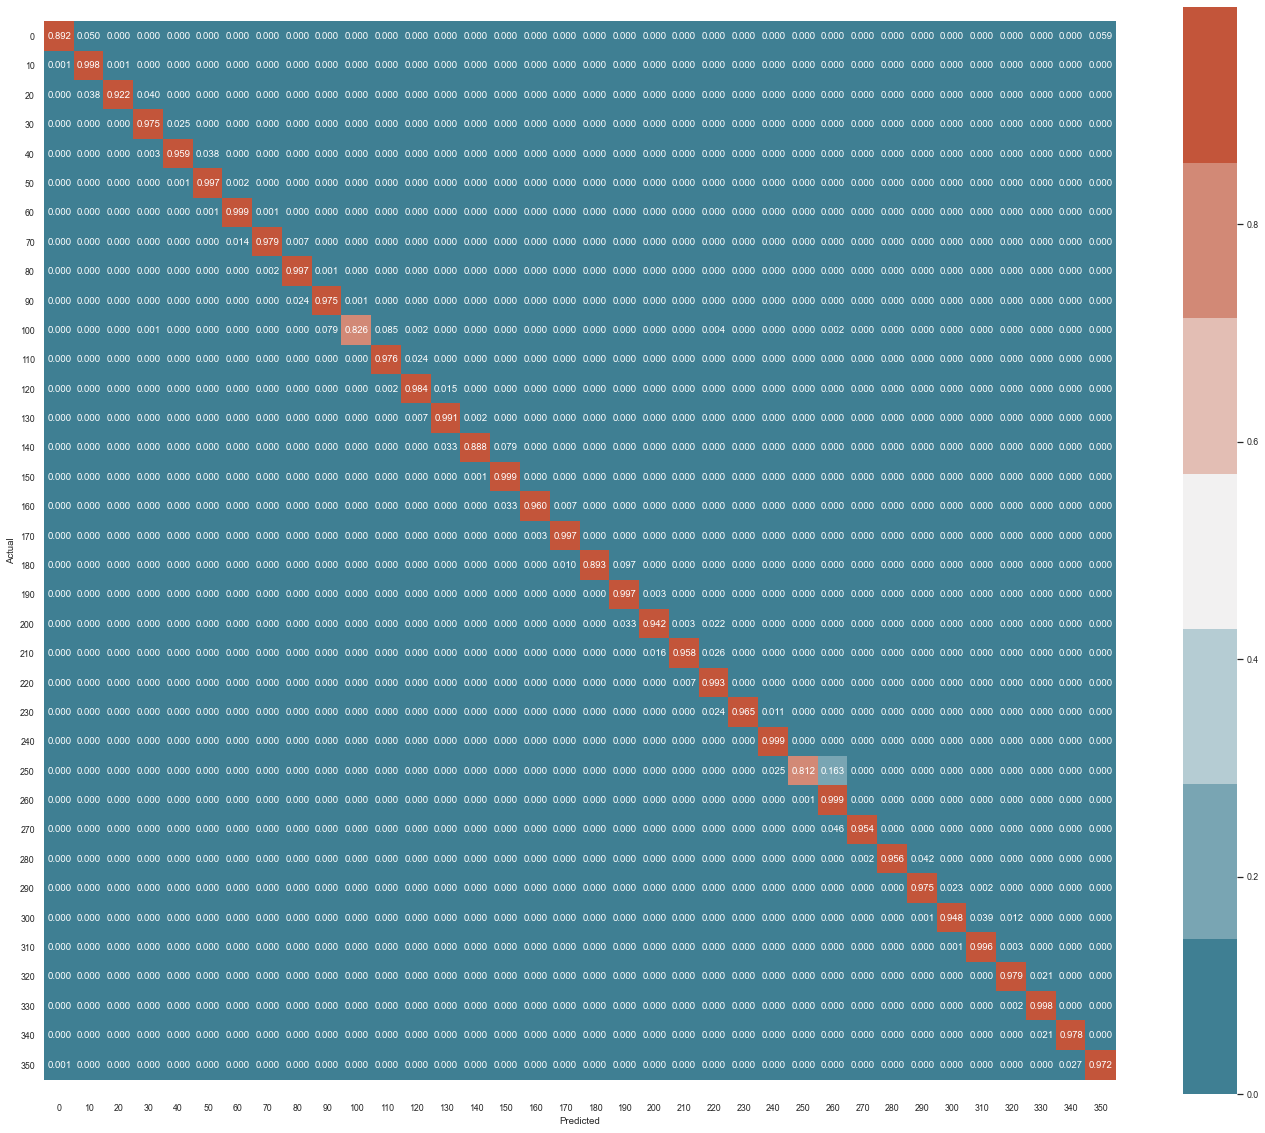

Accuracy: 0.961


In [39]:
# Test model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

y_pred_nn = model.predict(X_test)
y_pred_nn = encoder.inverse_transform(y_pred_nn)
y_true_nn = encoder.inverse_transform(y_test)
plot_cm(y_true_nn, y_pred_nn, np.unique(y_true_nn))
print(f'Accuracy: {round(accuracy, 3)}')

Here we can check the performance of the network for different room sizes and distances:

In [40]:
def evaluate_for_property(prop, value):
    """
    Measures the model prediction for test samples
    with a given property, such as room size.
    """
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Filter test set by property value
    X_trn, y_trn, X_tst, y_tst = create_whole_dataset(
        df_train, df_test[df_test[prop]==value], encoder
    )
    
    # Evaluate the model on the filtered set
    X_tst = np.transpose(X_tst, axes=[0, 2, 1])
    loss, acc = model.evaluate(X_tst, y_tst, batch_size=batch_size, verbose=0)
    
    return round(loss, 3), round(acc, 3)

In [41]:
# Evaluate performance for different properties

print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property('room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property('dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.961
medium room accuracy: 0.96
large room accuracy: 0.962

Distances
50 cm distance accuracy: 0.888
150 cm distance accuracy: 0.995
200 cm distance accuracy: 0.997
250 cm distance accuracy: 0.997
350 cm distance accuracy: 0.996
450 cm distance accuracy: 0.997


In [46]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('../models/model.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Tomek\AppData\Local\Temp\tmp2i4kn6n7\assets
